In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os
sys.path.append(os.path.abspath("../preprocessingPipelines")) 

from dataExtraction import *
from confound_first_level_pipeline import main
from noConfound_first_level_pipeline import main

#LIBSVM
from libsvm.svmutil import *

#nilearn imports
import nilearn
from nilearn import plotting, image, interfaces, maskers
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nibabel as nib
from nilearn.maskers import NiftiMasker

#sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def load_beta_data(topSubjects, data_type):
    taskType = ['colorwheel', 'samedifferent']
    num_runs = [1, 2, 3, 4]
    
    X, y = [], []

    for subjID in topSubjects:
        for task in taskType:
            for run in num_runs:
                try:
                    file_path = f"~/teams/a05/group_1_data/{data_type}Beta/beta_{subjID}_{task}_{run}.nii.gz"
                    
                    beta_img = nib.load(str(file_path))
                    
                    # getting the data as an array, then flattening to 1D feature vector for model training
                    mask_img = nilearn.datasets.load_mni152_brain_mask(resolution=2, threshold=0.2)
                    masker = NiftiMasker(mask_img=mask_img, memory="nilearn_cache", memory_level=1).fit()

                    #transform all the data to get the brain voxels
                    beta_data = masker.transform(beta_img).flatten()
                
                    X.append(beta_data)
    
                    # appending the task category to y
                    y.append(task)
                except:
                    #if there isn't a specific run, i.e. run 4
                    continue

    return np.array(X), y

In [6]:
def train_model(X, y):
    mask_img = nilearn.datasets.load_mni152_brain_mask(resolution=2, threshold=0.2)
    masker = NiftiMasker(mask_img=mask_img, memory="nilearn_cache", memory_level=1).fit()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # SVM classifier
    svm_model = svm_train(y_train, X_train)
    svm_save_model('svm_beta_model', svm_model)
    y_pred, accuracy, _ = svm_predict(y_test, X_test, svm_model)
    

    # Evaluate performance
    print("Model Accuracy: " + str(accuracy))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    show()

    #print 3D model of predicted brain
    support_vectors_dict = svm_model.get_SV()
    max_feature_index = max(max(sv.keys()) for sv in support_vectors_dict)
    
    support_vectors = np.zeros((len(support_vectors_dict), max_feature_index))
    
    for i, sv in enumerate(support_vectors_dict):
        for key, value in sv.items():
            support_vectors[i, key - 1] = value 
    
    #get dual coefficients (alpha * y)
    dual_coefficients = np.array(svm_model.get_sv_coef()).flatten()
    
    #compute weight vector
    weight_1d = np.sum(support_vectors.T * dual_coefficients, axis=1)
    
    weights_3d = masker.inverse_transform(weight_1d)
    plotting.plot_stat_map(weights_3d, vmax=2, alpha=0.5, title=f"Weighted Brain")

    return svm_model

In [4]:
subjects = [103, 105, 106, 109, 110, 115, 117, 124, 
           127, 130, 131, 133, 138, 140, 142, 143, 145,
           147, 157, 159, 161, 165, 172, 176, 177, 178,
           180, 181, 182, 183, 188, 200, 207, 208]

X, y = load_beta_data(subjects, 'nonConfound')
y = [1 if task == 'colorwheel' else 0 for task in y]

*
optimization finished, #iter = 201
nu = 0.695975
obj = -95.893575, rho = 0.391659
nSV = 186, nBSV = 109
Total nSV = 186
Accuracy = 89.0909% (49/55) (classification)
Model Accuracy: (89.0909090909091, 0.10909090909090909, 0.6260389036251105)


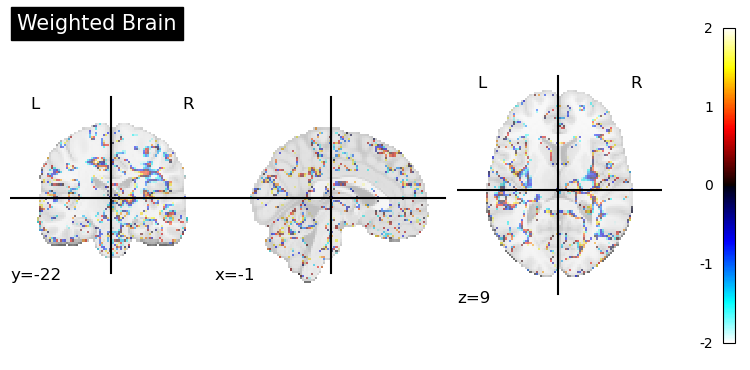

In [7]:
train_model(X, y)

/home/yhung/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images


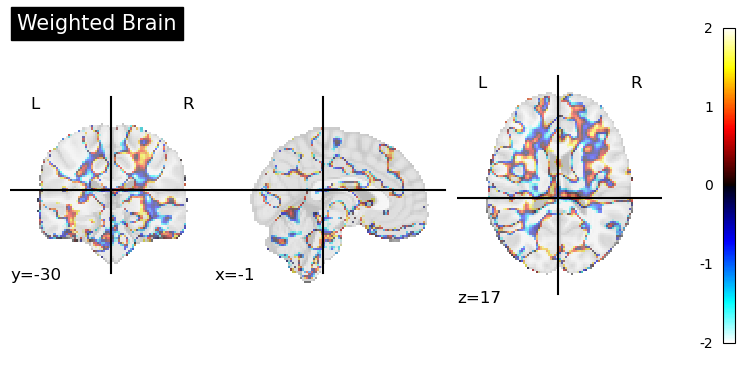

In [8]:
X1, y1 = load_beta_data(subjects, 'confound')
y1 = [1 if task == 'colorwheel' else 0 for task in y1]
train_model(X1, y1)

In [ ]:
help(svm_predict)

In [ ]:
help(svm_train)